In [16]:
import pickle
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import pingouin 
from utils import load_params
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
lottery_objs = load_params.load_lotteries()
set_dicts = load_params.load_set_dicts()
behavior_results = load_params.load_behavior_results()
set_objs = load_params.load_sets(behavior_results)
first_subjects, replication_subjects = load_params.load_samples(roi_type='roi')
first_subjects_schaefer, replication_subjects_schaefer = load_params.load_samples(roi_type='schaefer')

In [3]:
def effective_dim_n2(subject, roi):
    roi_rep = subject.avg_representation[roi]
    # drop nans
    nan_reps = np.isnan(roi_rep).any()
    if nan_reps:
        print(f'removing {subject.sub_num} due to NaNs in representation')
        return np.nan
    pca = PCA()
    pca.fit(roi_rep)
    effective_dims = np.sum(pca.explained_variance_)**2 / np.sum(pca.explained_variance_**2)
    return effective_dims

In [4]:
def effective_dim_per_roi(subjects, sort=True, order=None):
    rois = list(subjects[0].RDM.keys())
    if 'whole_brain' in rois:
        rois.remove('whole_brain')
    effective_dim_df = pd.DataFrame(columns=rois, dtype=float)
    for roi in rois:
        i = 0
        for subject in subjects:
            roi_effective_dims = effective_dim_n2(subject, roi)
            effective_dim_df.loc[i, roi] = roi_effective_dims        
            i += 1
    if sort:
        avg_dims = effective_dim_df.mean()
        roi_order = avg_dims.argsort()
        effective_dim_df = effective_dim_df.iloc[:, roi_order.values]
    elif order is not None:
        effective_dim_df = effective_dim_df.loc[:, order]
    return effective_dim_df

In [5]:
def average_effective_dims(effective_dim_df):
    mean_effective_dims = effective_dim_df.mean()
    if mean_effective_dims.shape[0] > 8:
        # schaefer
        mean_effective_dims = mean_effective_dims.reset_index()
        mean_effective_dims.columns = ['area', 'effective_dims']
        mean_effective_dims.loc[:, 'label'] = mean_effective_dims['area'].str.split('_').str[1].astype(int)
    else:
        # roi
        mean_effective_dims = mean_effective_dims.reset_index()
        mean_effective_dims.columns = ['label', 'effective_dims']
    return mean_effective_dims

In [6]:
first_roi_effective = effective_dim_per_roi(first_subjects)
replication_roi_effective = effective_dim_per_roi(replication_subjects)
first_schaefer_effective = effective_dim_per_roi(first_subjects_schaefer)
replication_schaefer_effective = effective_dim_per_roi(replication_subjects_schaefer)

In [7]:
first_roi_effective_mean = average_effective_dims(first_roi_effective)
replication_roi_effective_mean = average_effective_dims(replication_roi_effective)
first_schaefer_effective_mean = average_effective_dims(first_schaefer_effective)
replication_schaefer_effective_mean = average_effective_dims(replication_schaefer_effective)

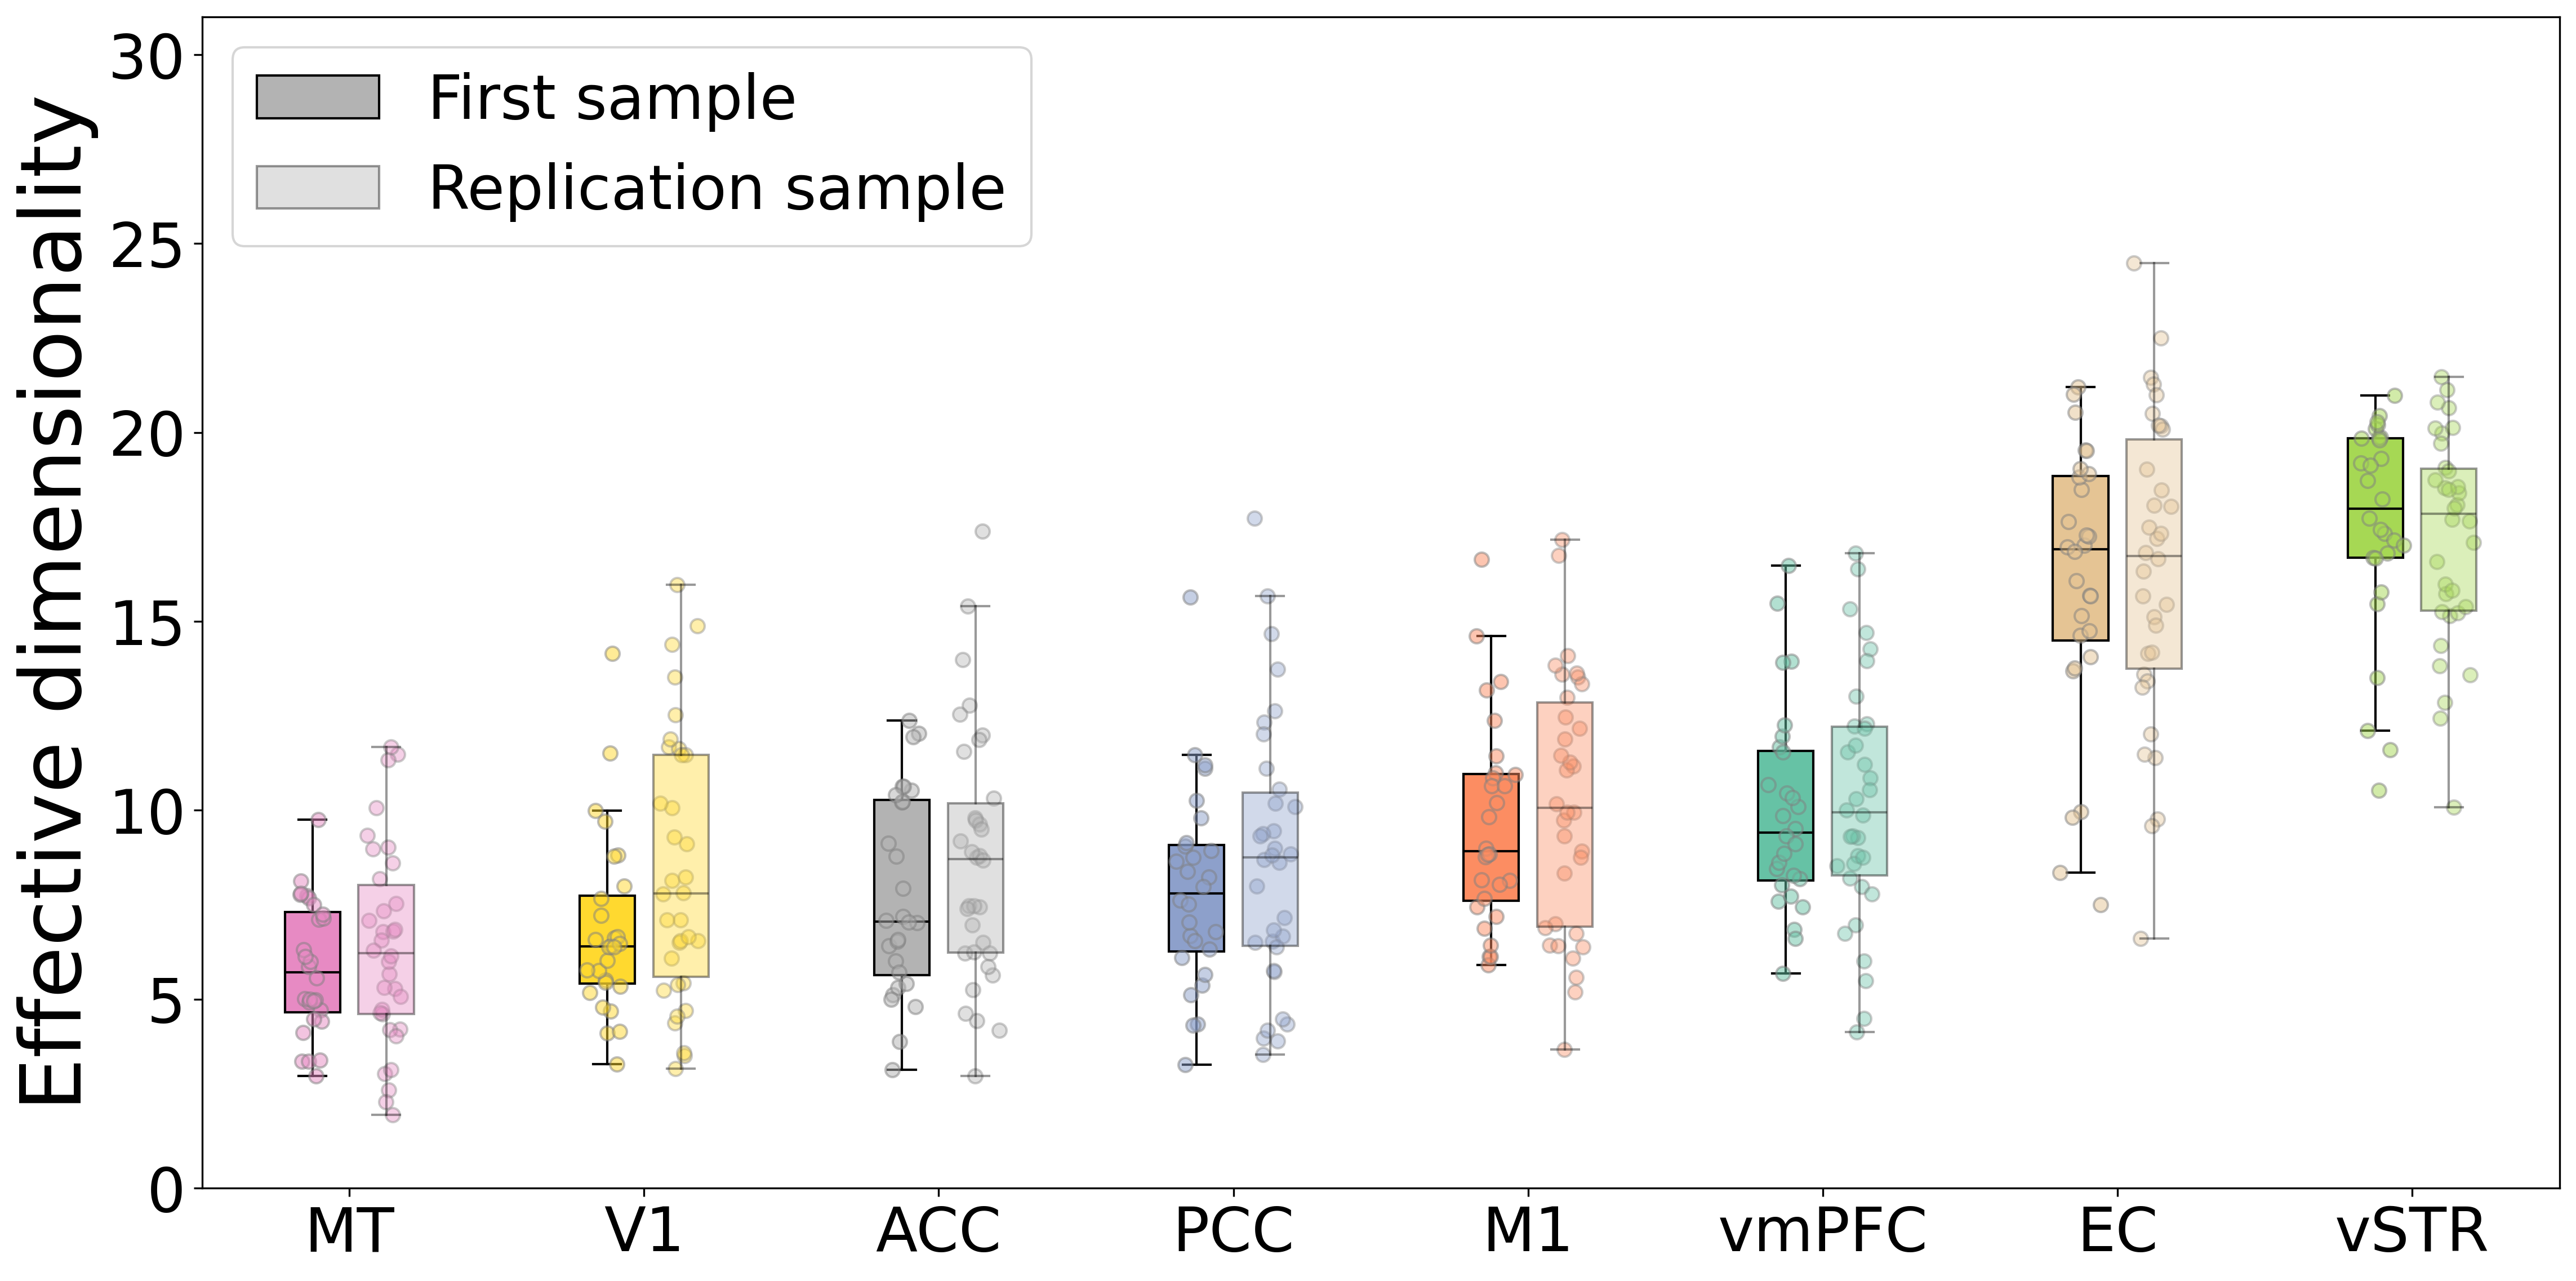

In [8]:
predefined_rois = [ 'vmPFC', 'M1', 'PCC', 'MT', 'vSTR','V1', 'EC', 'ACC']
n_predefined = len(predefined_rois)
column_list = first_roi_effective_mean.label.values
roi_order = [predefined_rois.index(roi) for roi in column_list]
bar_colors = np.array(sns.color_palette('Set2', n_colors=n_predefined))
bar_colors = bar_colors[roi_order]

tick_size = 26
label_size = 36
nudge_magnitude = 0.5
box_width = 0.75

plt.figure(figsize=(18, 9), dpi=300)
boxplot_positions = np.arange(0, 32, 4)
first_boxplot = plt.boxplot(first_roi_effective, positions=boxplot_positions-nudge_magnitude, 
                            widths=box_width, patch_artist=True, showfliers=False,
                            medianprops={'color':'black'}, zorder=-1)
replication_boxplot = plt.boxplot(replication_roi_effective, positions=boxplot_positions+nudge_magnitude, 
                                  widths=box_width, patch_artist=True, showfliers=False,
                                  medianprops={'color':'black', 'alpha':0.4}, 
                                  boxprops={'alpha':0.4},
                                  whiskerprops={'alpha':0.4},
                                  capprops={'alpha':0.4},
                                  flierprops={'alpha':0.4})
plt.ylabel('Effective dimensionality', fontsize=label_size)
_ = plt.xticks(boxplot_positions, first_roi_effective.columns, fontsize=tick_size)
plt.yticks(fontsize=tick_size)

for patch_first, patch_replication, color in zip(first_boxplot['boxes'], replication_boxplot['boxes'], bar_colors):
    patch_first.set_facecolor(color)
    patch_replication.set_facecolor(color)

scattered_plot_std = 0.12
i = 0
for _, row in first_roi_effective.T.iterrows():
    scattered_positions = [np.random.normal(0, scattered_plot_std) for j in range(len(row))]
    plt.scatter(boxplot_positions[i] - nudge_magnitude + scattered_positions, row, alpha=0.5, color=bar_colors[i], edgecolors='grey')
    i += 1

i = 0
for _, row in replication_roi_effective.T.iterrows():
    scattered_positions = [np.random.normal(0, scattered_plot_std) for j in range(len(row))]
    plt.scatter(boxplot_positions[i] + nudge_magnitude + scattered_positions, row, alpha=0.4, color=bar_colors[i], edgecolors='grey')
    i += 1

plt.legend( handles=[first_boxplot['boxes'][2], replication_boxplot['boxes'][2]], 
            labels=['First sample', 'Replication sample'], loc='upper left', fontsize=tick_size)
plt.ylim([0, 31])
plt.xlim([boxplot_positions[0]-2, boxplot_positions[-1]+2])
plt.savefig('../../results/figs/fig4/ED.png', bbox_inches='tight')

### pairwise comparisons between ED

In [9]:
rois = first_roi_effective_mean.label
first_pval_df = pd.DataFrame(columns=rois, index=rois, dtype=float)
replication_pval_df = first_pval_df.copy()
for i, roi_i in enumerate(rois[:-1]):
    for j, roi_j in enumerate(rois[i+1:]):
        first_roi_i_dims = first_roi_effective.loc[:, roi_i]
        first_roi_j_dims = first_roi_effective.loc[:, roi_j]
        replication_roi_i_dims = replication_roi_effective.loc[:, roi_i]
        replication_roi_j_dims = replication_roi_effective.loc[:, roi_j]
        first_t, first_p = scipy.stats.ttest_ind(first_roi_i_dims, first_roi_j_dims)
        replication_t, replication_p = scipy.stats.ttest_ind(replication_roi_i_dims, replication_roi_j_dims)
        first_pval_df.loc[roi_i, roi_j] = first_p
        replication_pval_df.loc[roi_i, roi_j] = replication_p

In [10]:
triu_indices = np.triu_indices_from(first_pval_df.values, k=1)
first_pvals = first_pval_df.values[triu_indices]
replication_pvals = replication_pval_df.values[triu_indices]

In [11]:
first_pval_df.values[triu_indices] = scipy.stats.false_discovery_control(first_pvals)
replication_pval_df.values[triu_indices] = scipy.stats.false_discovery_control(replication_pvals)

In [12]:
first_pval_df.values.T[triu_indices] = first_pval_df.values[triu_indices]
replication_pval_df.values.T[triu_indices] = replication_pval_df.values[triu_indices]

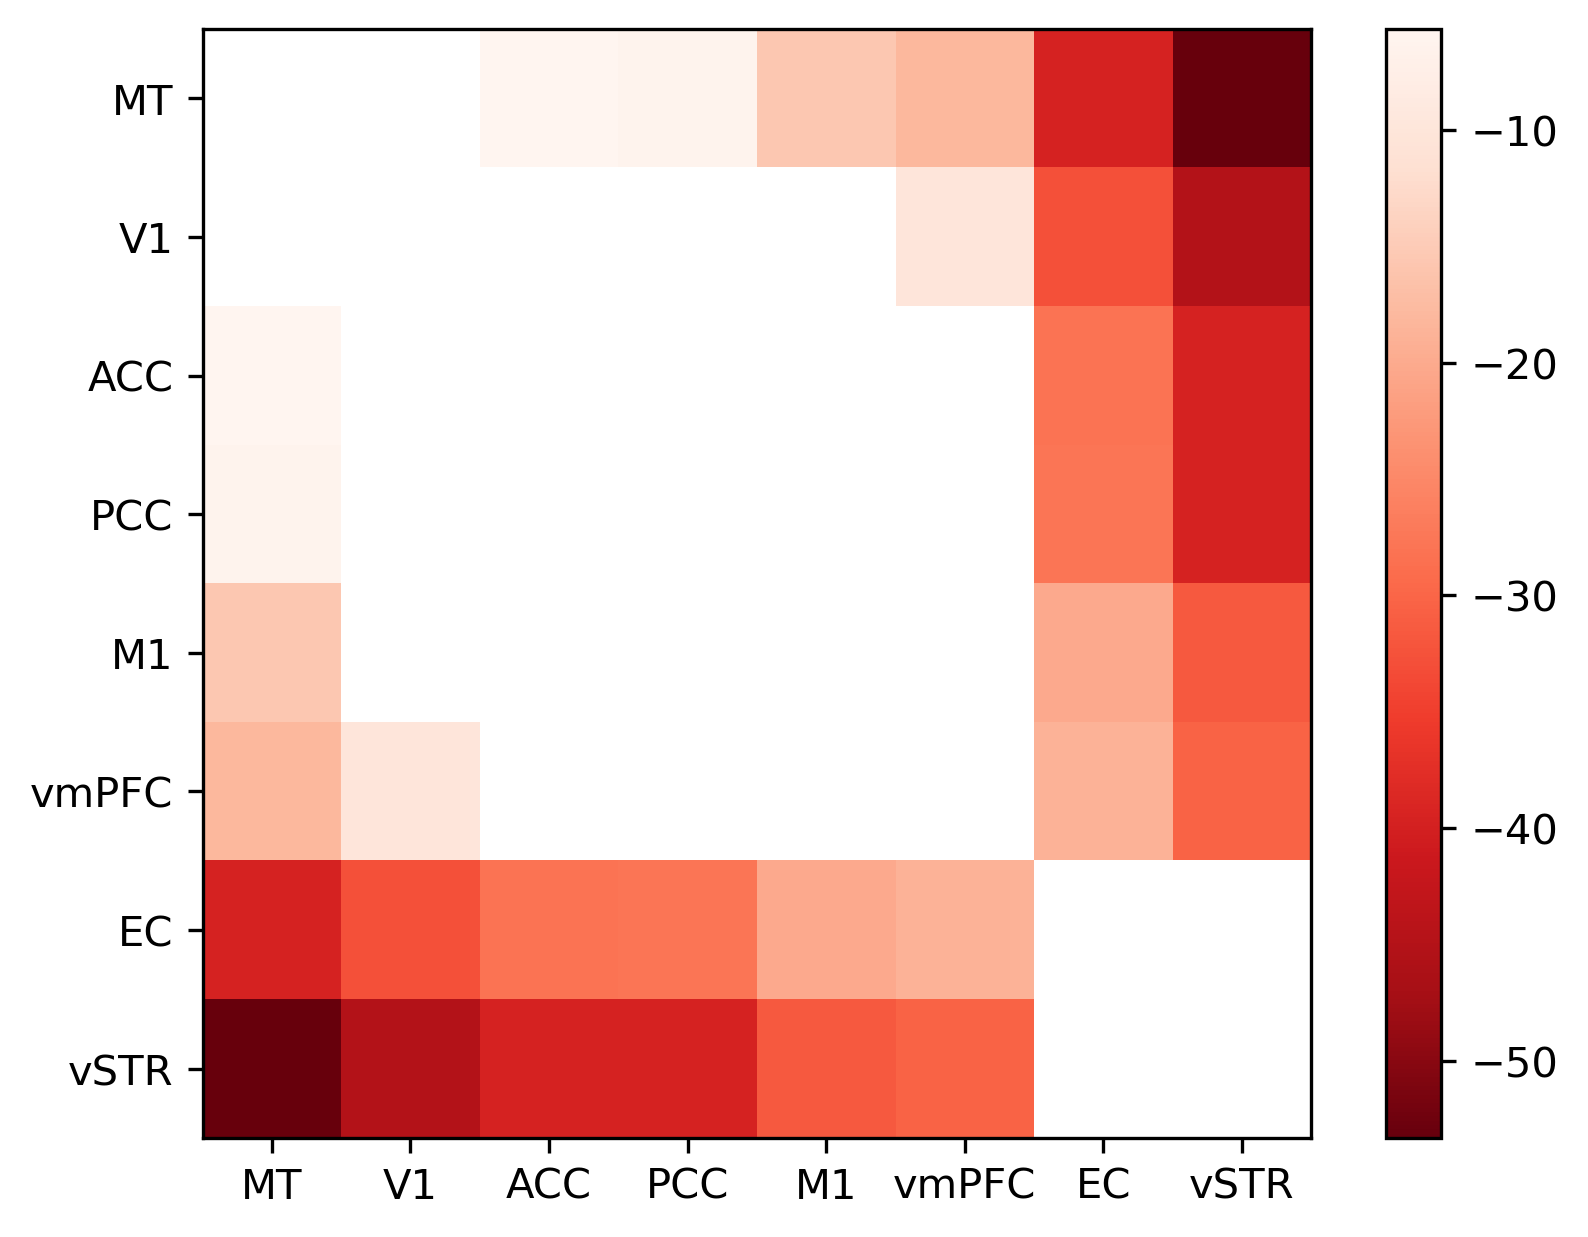

In [13]:
plt.figure(dpi=300)
plt.imshow(np.log(first_pval_df[(first_pval_df<0.05) & (replication_pval_df<0.05)]), cmap='Reds_r')
rois = first_pval_df.index.values
# ticks = plt.xticks()
plt.xticks(np.arange(len(rois)), rois)
plt.yticks(np.arange(len(rois)), rois)
plt.colorbar()

### example ED

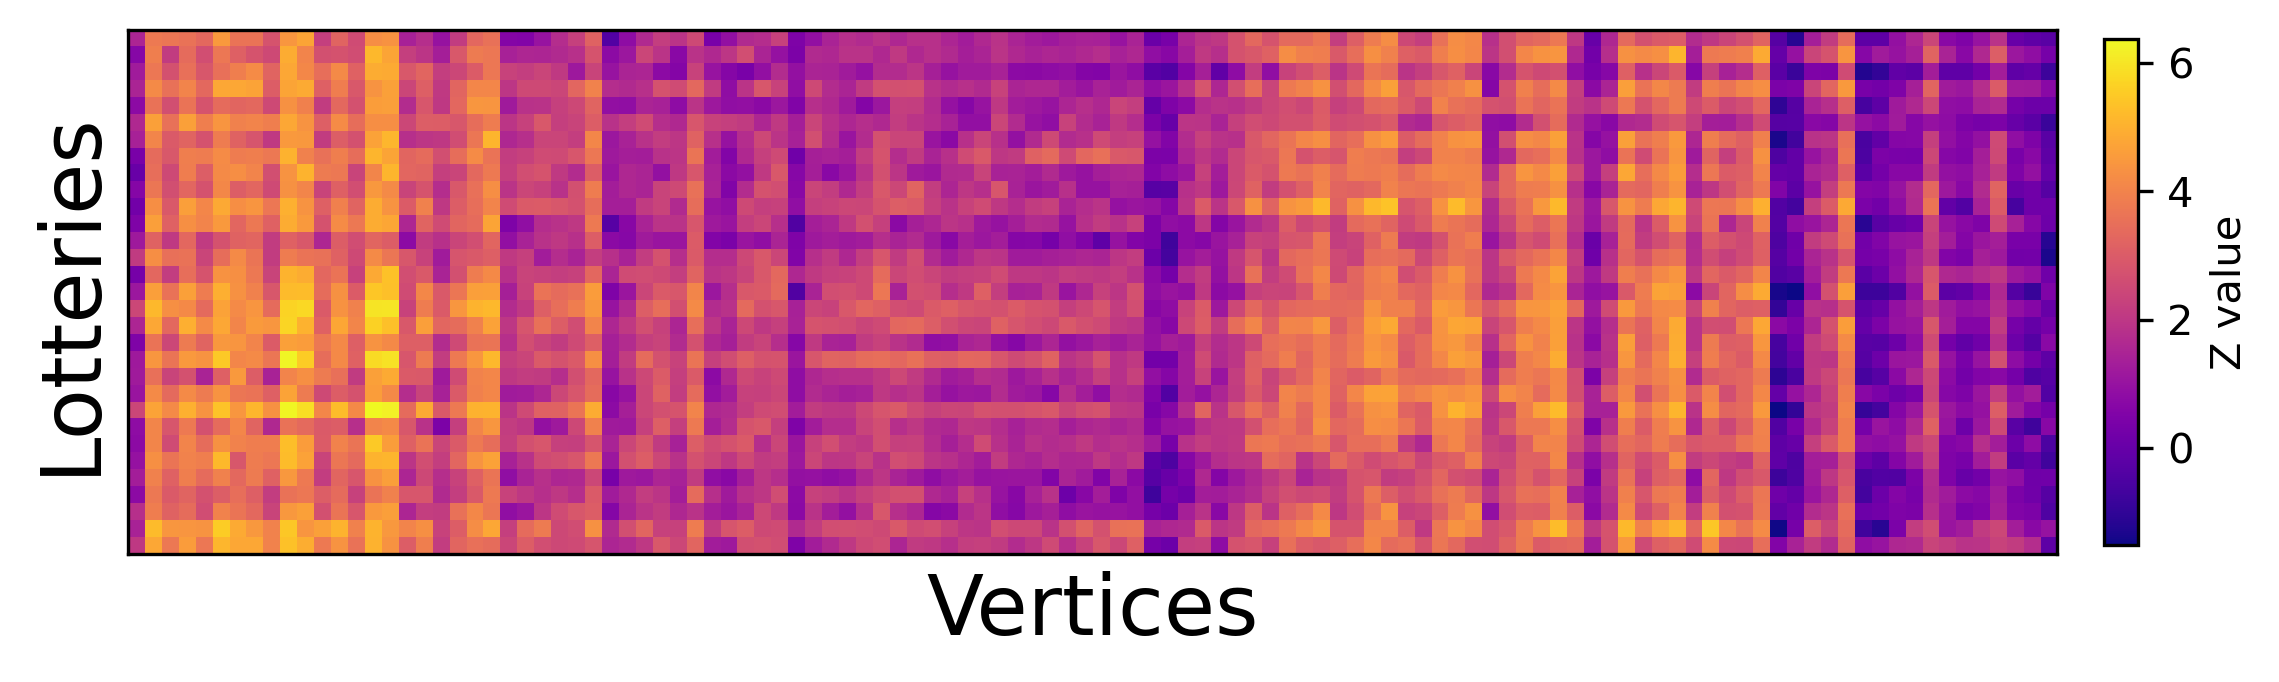

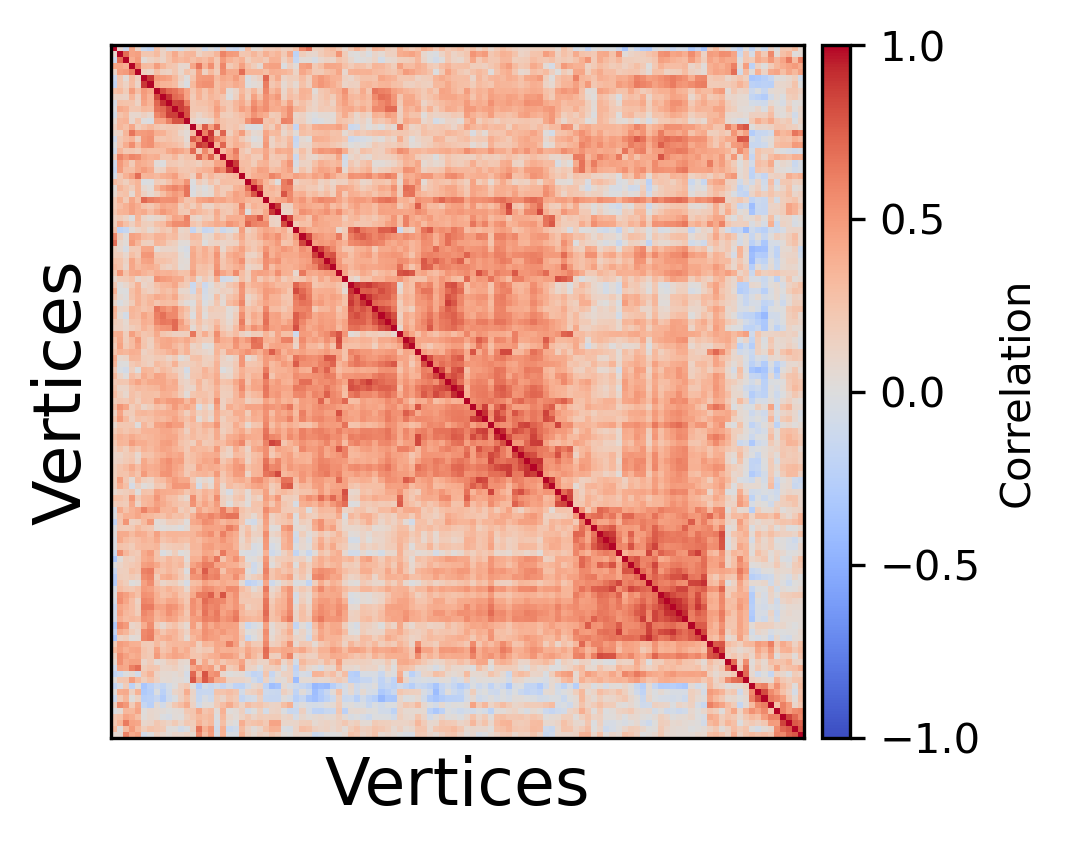

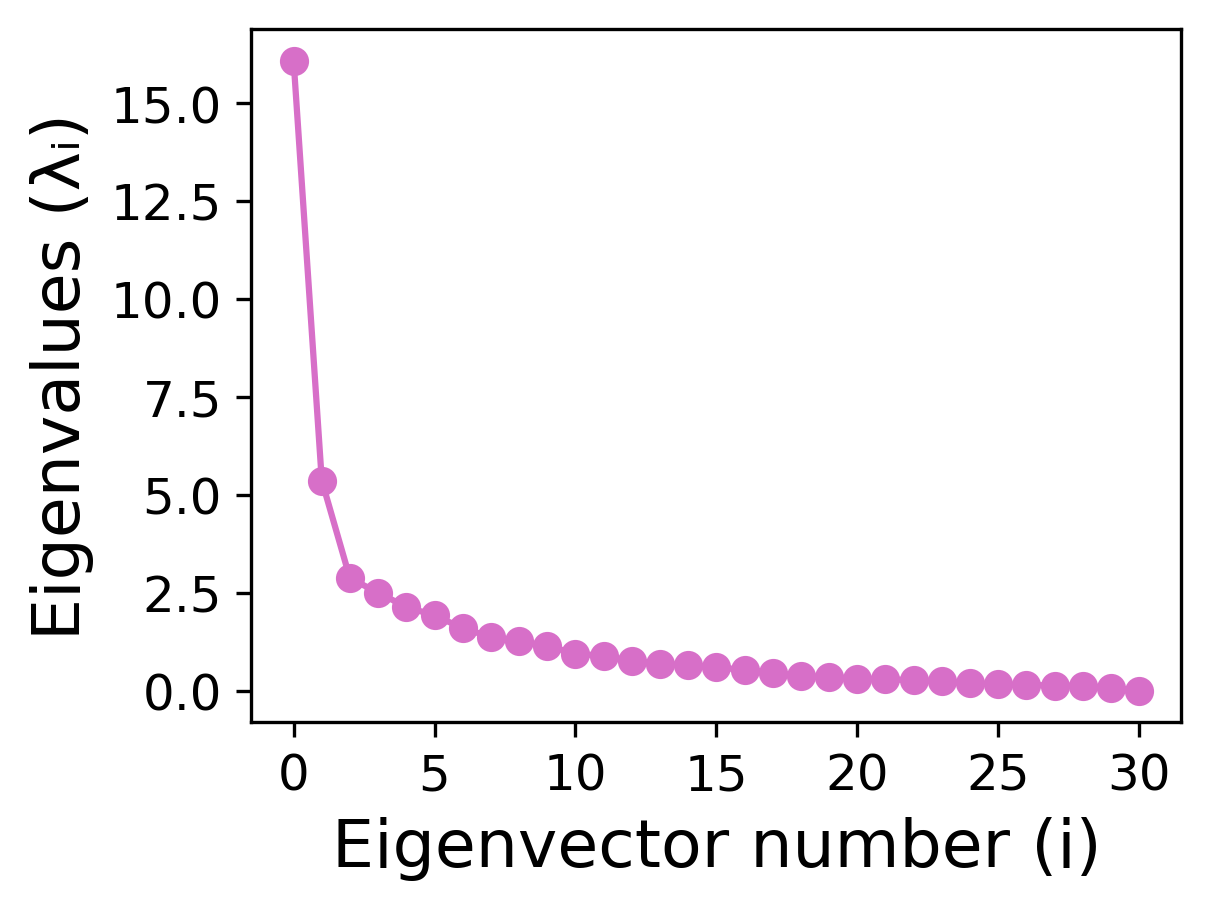

In [17]:
tick_size = 16
label_size = 20

s = first_subjects[20]
area_i = 7
areas = list(s.avg_representation.keys())[:-1]
area = areas[area_i]
s_rep = s.avg_representation[area]
s2 = first_subjects[11]
s2_rep = s2.avg_representation[area]
pca = PCA()
pca.fit(s_rep)
s_rep_corr = np.corrcoef(s_rep.T)
Z = linkage(s_rep_corr, method='single')
dendo = dendrogram(Z, no_plot=True)
sorted_ids = dendo['leaves']
# subject 1 representations
plt.figure(figsize=(10, 3), dpi=300)
plt.imshow(s_rep, cmap='plasma')
# plt.title(f'{area} Representations', fontsize=10)
plt.xlabel('Vertices', fontsize=label_size)
plt.ylabel('Lotteries', fontsize=label_size)
plt.xticks([], fontsize=tick_size)
# plt.yticks(ticks=np.arange(0, 31, 10), labels=np.arange(1, 32, 10), fontsize=tick_size)
plt.yticks([])
cbar = plt.colorbar(shrink=0.73, aspect=15, pad=0.02, label='Z value')
plt.savefig(f'../../results/figs/fig4/representations_{area}.png', bbox_inches='tight')

tick_size = 12
label_size = 16
# correlation matrix and effective dims
plt.figure(figsize=(4, 3), dpi=300)
plt.imshow(s_rep_corr[sorted_ids, :][:, sorted_ids], cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks([], fontsize=tick_size)
plt.xticks([], fontsize=tick_size)
plt.xlabel('Vertices', fontsize=label_size)
plt.ylabel('Vertices', fontsize=label_size)
cbar = plt.colorbar(aspect=25, pad=0.02, label='Correlation', ticks=[1, 0.5, 0, -0.5, -1])
effective_dims = np.sum(pca.explained_variance_)**2 / np.sum(pca.explained_variance_**2)
plt.savefig(f'../../results/figs/fig4/corr_matrix_{area}.png', bbox_inches='tight')

# explained variance
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(np.arange(len(pca.explained_variance_)), pca.explained_variance_, color='#d76fc8') # EC: e5c494, vSTR: 8fbf3f, MT: d76fc8
plt.scatter(np.arange(len(pca.explained_variance_)), pca.explained_variance_, color='#d76fc8')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel('Eigenvalues (λ\u1d62)', fontsize=label_size) # \u1d62 is the unicode for subscript "i"
plt.xlabel('Eigenvector number (i)', fontsize=label_size)
plt.savefig(f'../../results/figs/fig4/pca_scree_plot_{area}.png', bbox_inches='tight')

### ED, attribute representation level, and RMSE

In [18]:
first_attribute_level = pd.read_csv('../../results/first_results/first_schaefer419_attribute_level.csv')
replication_attribute_level = pd.read_csv('../../results/replication_results/replication_schaefer419_attribute_level.csv')
first_effective_dims = pd.read_csv('../../results/first_results/first_schaefer419_effective_dims.csv')
replication_effective_dims = pd.read_csv('../../results/replication_results/replication_schaefer419_effective_dims.csv')
labels = pd.read_csv('../../results/schaefer419_labels.csv', index_col=0)

network_colors = {  'Vis' : '#721D81',
                    'DorsAttn' : '#3E8B2A',
                    'Default' : '#D15558',
                    'SalVentAttn' : '#E45DF7',
                    'SomMot' : '#6EA2CE',
                    'Cont' : '#F4BA49',
                    'Limbic' : '#c8cf9b',
                    'Subcortex' : "#d0d0d0"}

In [19]:
with open('../../results/first_results/cv/first_random_8_schaefer_rmse_rois.pkl', 'rb') as f:
    first_permutation_results = pickle.load(f)
with open('../../results/replication_results/cv/replication_random_8_schaefer_rmse_rois.pkl', 'rb') as f:
    replication_permutation_results = pickle.load(f)

In [20]:
def combine_attribute_ed_rmse(attribute_df, ed_df, rmse_rois):
    roi_combination_attribute_rmse = pd.DataFrame(columns=['roi'+str(i) for i in range(1, 9)] + ['RMSE'])
    roi_combination_ed_rmse = pd.DataFrame(columns=['roi'+str(i) for i in range(1, 9)] + ['RMSE'])
    for i, row in rmse_rois.iterrows():
        rois = row.rois
        if len(rois) != 8:
            continue
        rois_attribute = attribute_df.loc[attribute_df.area.isin(rois), 'rdm_r'].values.tolist()
        rois_attribute.append(row.rmse)
        rois_ed = ed_df.loc[ed_df.area.isin(rois), 'effective_dims'].values.tolist()
        rois_ed.append(row.rmse)
        roi_combination_attribute_rmse.loc[i, :] = rois_attribute
        roi_combination_ed_rmse.loc[i, :] = rois_ed
    roi_combination_attribute_rmse.loc[:, 'mean_attribute_level'] = roi_combination_attribute_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].mean(axis=1)
    roi_combination_attribute_rmse.loc[:, 'std_attribute_level'] = roi_combination_attribute_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].std(axis=1)
    roi_combination_attribute_rmse.loc[:, 'max_attribute_level'] = roi_combination_attribute_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].max(axis=1)
    roi_combination_attribute_rmse.loc[:, 'min_attribute_level'] = roi_combination_attribute_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].min(axis=1)
    roi_combination_ed_rmse.loc[:, 'mean_ed'] = roi_combination_ed_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].mean(axis=1)
    roi_combination_ed_rmse.loc[:, 'std_ed'] = roi_combination_ed_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].std(axis=1)
    roi_combination_ed_rmse.loc[:, 'max_ed'] = roi_combination_ed_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].max(axis=1)
    roi_combination_ed_rmse.loc[:, 'min_ed'] = roi_combination_ed_rmse.loc[:, ['roi'+str(i) for i in range(1, 9)]].min(axis=1)
    return roi_combination_attribute_rmse, roi_combination_ed_rmse

In [21]:
first_effective_dims = first_effective_dims.sort_values('label')
replication_effective_dims = replication_effective_dims.sort_values('label')

In [22]:
first_comb_attribute_rmse, first_comb_ed_rmse = combine_attribute_ed_rmse(  first_attribute_level, 
                                                                            first_effective_dims, 
                                                                            first_permutation_results)
replication_comb_attribute_rmse, replication_comb_ed_rmse = combine_attribute_ed_rmse(  replication_attribute_level, 
                                                                                        replication_effective_dims, 
                                                                                        replication_permutation_results)

In [23]:
first_comb_attribute_rmse = first_comb_attribute_rmse.astype(float)
replication_comb_ed_rmse = replication_comb_ed_rmse.astype(float)
replication_comb_attribute_rmse = replication_comb_attribute_rmse.astype(float)
first_comb_ed_rmse = first_comb_ed_rmse.astype(float)

In [24]:
pingouin.corr(first_comb_attribute_rmse.RMSE, first_comb_attribute_rmse.mean_attribute_level, method='bicor')

,n,r,CI95%,p-val,power
bicor,10000,0.08661,"[0.07, 0.11]",4.089613e-18,1.0


In [25]:
pingouin.corr(first_comb_ed_rmse.RMSE, first_comb_ed_rmse.mean_ed, method='bicor')

,n,r,CI95%,p-val,power
bicor,10000,-0.024035,"[-0.04, -0.0]",0.016238,0.671382


In [26]:
pingouin.corr(replication_comb_ed_rmse.RMSE, replication_comb_ed_rmse.mean_ed, method='bicor')

,n,r,CI95%,p-val,power
bicor,10000,-0.056391,"[-0.08, -0.04]",1.671893e-08,0.999885


In [27]:
pingouin.corr(replication_comb_attribute_rmse.RMSE, replication_comb_attribute_rmse.mean_attribute_level, method='bicor')

,n,r,CI95%,p-val,power
bicor,10000,0.074536,"[0.06, 0.09]",8.455791e-14,1.0


### Attribute representation level vs effective dimensionality

In [28]:
merged_first_ed_rdm_r = first_effective_dims.merge(first_attribute_level, on='label')[['label', 'rdm_r', 'effective_dims']]
merged_first_ed_rdm_r = merged_first_ed_rdm_r.merge(labels, on='label')

merged_replication_ed_rdm_r = replication_effective_dims.merge(replication_attribute_level, on='label')[['label', 'rdm_r', 'effective_dims']]
merged_replication_ed_rdm_r = merged_replication_ed_rdm_r.merge(labels, on='label')

In [29]:
def plot_attribute_represntation_level_and_effective_dims(rmse_rdm_r, column='effective_dims', column_thresh=None, save_path=None):
    axis_label_size = 20
    tick_label_size = 16
    n_rows = 1
    n_cols = len(rmse_rdm_r)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6), dpi=300, sharey=True)
    col = 0
    rmse_rdm_r_list = rmse_rdm_r.copy()
    for ax, rmse_rdm_r_df in zip(axs, rmse_rdm_r_list):
        if column_thresh is not None:
            rmse_rdm_r_df = rmse_rdm_r_df.loc[rmse_rdm_r_df[column] < column_thresh]
        bicor = pingouin.corr(rmse_rdm_r_df[column], rmse_rdm_r_df.rdm_r, method='bicor')
        r = bicor.r.values[0]
        pval = bicor['p-val'].values[0]
        for i, network in enumerate(network_colors.keys()):
            network_rows = rmse_rdm_r_df.loc[rmse_rdm_r_df.network==network]
            ax.scatter(network_rows.rdm_r, network_rows[column], 
                        c=network_colors[network], alpha=0.5, label=network)
        if column_thresh is None:
            ax.set_xlabel('Attribute representation level', fontsize=axis_label_size)
            if col==0:
                yticks = ax.get_yticks()
                ylabels = ax.get_yticklabels()
                ax.set_ylabel('Effective dimensionality', fontsize=axis_label_size)
                ax.set_yticks(yticks)
                ax.set_yticklabels(ylabels, fontsize=tick_label_size)
            xticks = ax.get_xticks()
            xlabels = ax.get_xticklabels()
            ax.set_xticks(xticks[::2])
            ax.set_xticklabels(xlabels[::2], fontsize=tick_label_size)
        else:
            ax.set_yticks([])
            ax.set_xticks([])
        if column_thresh is None:
            y_text = np.ceil(rmse_rdm_r_df[column].max()) - 0.4
            x_text = -0.18
        else:
            y_text = np.ceil(rmse_rdm_r_df[column].max()) - 0.6
            x_text = 0.15
        pval_exponent = np.abs(int(np.log10(pval)))
        if pval_exponent == 9:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-8}$', style='italic', fontsize=tick_label_size)
        elif pval_exponent == 10:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-9}$', style='italic', fontsize=tick_label_size)
        elif pval_exponent == 11:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-10}$', style='italic', fontsize=tick_label_size)
        elif pval_exponent == 12:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-11}$', style='italic', fontsize=tick_label_size)
        elif pval_exponent == 13:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-12}$', style='italic', fontsize=tick_label_size)
        elif pval_exponent == 14:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-13}$', style='italic', fontsize=tick_label_size)
        elif pval_exponent == 15:
            ax.text(x_text, y_text, '$r_{bicor}$' + f' = {r:.4f}' + ', p < $10^{-14}$', style='italic', fontsize=tick_label_size)
        ax.set_xlim([-0.2, 0.68])
        col += 1
    if column_thresh is None:
        ax.legend(loc=(0.675, 0.575))
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

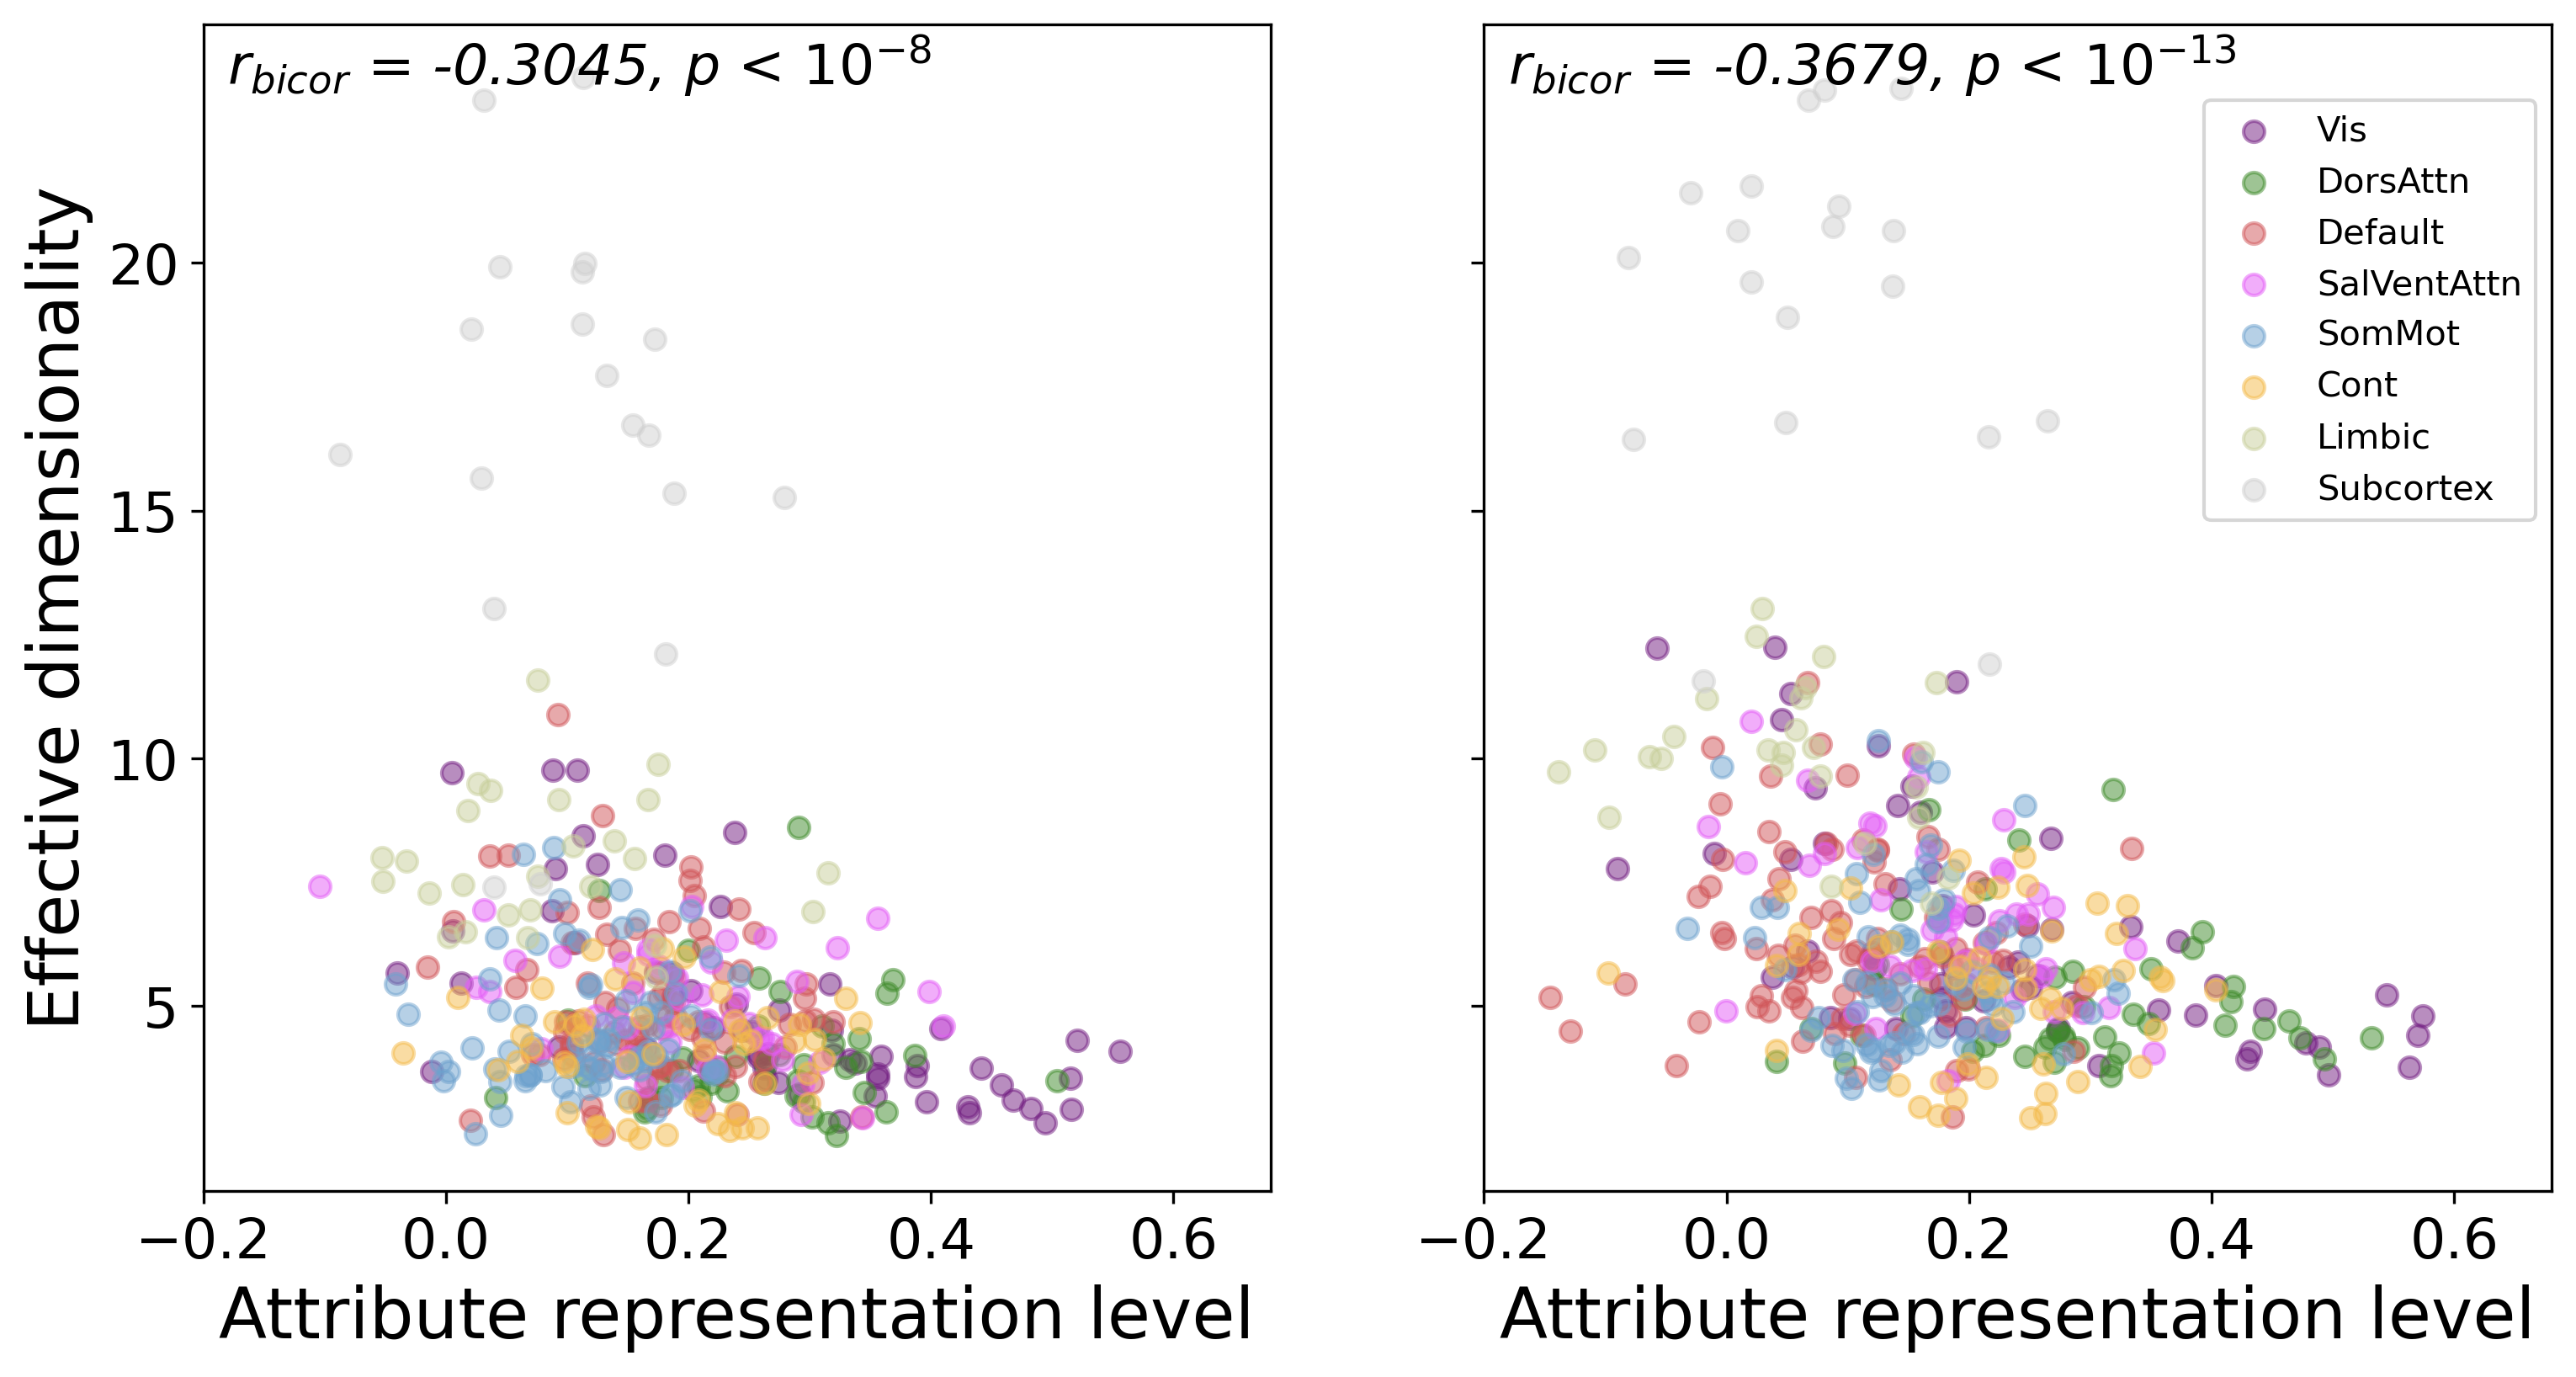

In [30]:
plot_attribute_represntation_level_and_effective_dims([merged_first_ed_rdm_r, merged_replication_ed_rdm_r], column='effective_dims')